# Points à vérifier dans mon code: 

### Il faut produire une séquence d'étape complète et cohérente : 
- Sépration en K-fold
- Utilisation du premier fold pour faire un HP-tuning 
- Utilisations des K-1 fold restant pour récupérer une métrique dans le cas globale
- Utilisation des K-1 fold restant pour récupérer une métrique sur les peak hour 
- Zoom sur les quelques rares cas particulier/atypique qu'on arrive à identifier dans la dataset de test. 

----
Je n'ai pas clean la NetMob DataSet (valeur interdite, preprocessing)
---
---

Penser à vérifier mes MetaData lors de la créations de mes tensors, pour être sûr de l'ordre que j'utilise (Nom des applications, DownLoad/Upload, Cellules Tile-ids ...)

In [1]:
# ========= PERSONAL_INPUT =========
# >>>> 
# >>>> PB_1 : Il faut absolument pouvoir prendre en compte les invalid dates de tout le monde.
# >>>> 1. Il le faire en amont. i.e lorsqu'on load les données, on load aussi les invalid dates associées
# >>>> 2. Puis on fait l'union des invalid dates
# >>>> 3. Après ça on train/valid/test split normalize tout.
# >>>> 
# >>>> PB_2: Idem pour le coverage pour que ça corresponde à tout le monde.  
# >>>> 
# >>>> PB_3 : Génère des input de taille différentes selon l'historique demandé. 
# >>>> Cela ne va pas convenir si jamais je travail avec du calendar class ou autre.
# >>>> 1. On peut donc enregistrer l'ensemble des invalid-dates
# >>>> 2. Créer les séquences/input_tensor associées 
# >>>> 3. Pour chaque donnée, on ne prend peut être pas en compte les même historiques. 
# >>>>    Donc on peut faire une liste de date 'D' correspondant à l'intersection de toute les target (df_verif[-1] ...?)
# >>>> 4. Puis on extrait l'ensemble des sequences de chaque Data sur D 

In [1]:
import sys
import os

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import pandas as pd
from trainer import Trainer
import matplotlib.pyplot as plt 
from examples.benchmark import local_get_args,get_inputs,get_trial_id,train_on_ds,keep_track_on_model_metrics

Training and Hyper-parameter tuning with Ray is not possible


Training and Hyper-parameter tuning with Ray is not possible

>>>>Training STGCN on ['subway_in', 'netmob_POIs']
40
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 28])
tensor size:  torch.Size([4, 28])
mean_values repeated:  torch.Size([4, 28])
>>>> Train/Valid/Test split method : similar_length_method



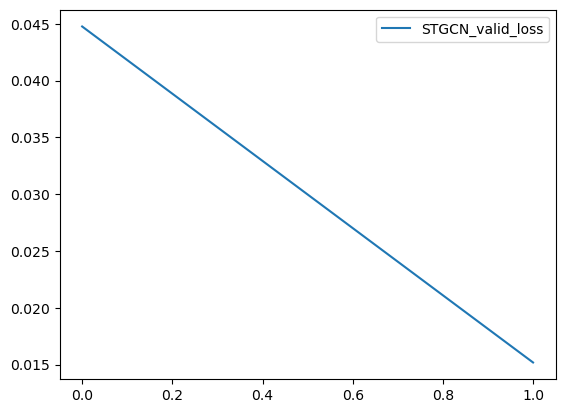

In [1]:
for dataset_names,vision_model_name in zip([['subway_in','netmob_POIs'],['subway_in']],['VariableSelectionNetwork',None]):
    # GET PARAMETERS
    #dataset_names = ['subway_in','netmob_POIs'] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']  # ['data_bidon','netmob_bidon'] #['netmob_POIs']
    dataset_for_coverage = ['subway_in','netmob_POIs'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY'] # ['data_bidon','netmob_bidon'] #['netmob_POIs'] 
    #vision_model_name = 'VariableSelectionNetwork' # None # 'VariableSelectionNetwork'

    from constants.paths import DATA_TO_PREDICT
    assert DATA_TO_PREDICT in dataset_names, f'You are trying to predict {DATA_TO_PREDICT} with only these data: {dataset_names}'
    save_folder = 'benchmark/fold0/'
    df_loss,df_results = pd.DataFrame(),pd.DataFrame()
    modification = {'epochs' : 2, #100,
                    }
    
    model_names = ['STGCN'] #  ['MTGNN','CNN','STGCN','LSTM','GRU','RNN'] #'DCRNN',
    print(f'\n>>>>Training {model_names[0]} on {dataset_names}')
    # Tricky but here we net to set 'netmob' so that we will use the same period for every combination
    args,folds,hp_tuning_on_first_fold = local_get_args(model_names[0],
                                                        None,
                                                        dataset_names=dataset_names,
                                                        dataset_for_coverage=dataset_for_coverage,
                                                        modification = modification)
    trial_id = get_trial_id(args,vision_model_name=vision_model_name)
    K_fold_splitter,K_subway_ds,dic_class2rpz = get_inputs(args,vision_model_name,folds)
    ds = K_subway_ds[0]

    trainer,df_loss = train_on_ds(model_names[0],ds,args,trial_id,save_folder,dic_class2rpz,df_loss)
    metrics = trainer.metrics
    df_results = keep_track_on_model_metrics(trainer,df_results,model_names[0],trainer,metrics)
    for model_name in model_names[1:]:  # benchamrk on all the other models, with the same input base['MTGNN','STGCN', 'CNN', 'DCRNN']
        print(f'\n>>>>Training {model_name} on {dataset_names}')
        args,folds,hp_tuning_on_first_fold = local_get_args(model_name,
                                                            args,
                                                            dataset_names=dataset_names,
                                                            dataset_for_coverage=dataset_for_coverage,
                                                            modification = modification)
        trial_id = get_trial_id(args,vision_model_name=vision_model_name)
        trainer,df_loss = train_on_ds(model_name,ds,args,trial_id,save_folder,dic_class2rpz,df_loss)
        metrics = trainer.metrics
        df_results = keep_track_on_model_metrics(trainer,df_results,model_name,trainer,metrics)

    print(df_results)
    df_loss[[f"{model}_valid_loss" for model in model_names]].plot()
    df_results.to_csv(f'{parent_dir}/save/results/{trial_id}.csv')
    plt.show()
    break

In [7]:
from examples.train_model_on_k_fold_validation import train_valid_K_models,save_model_metrics
import numpy as np 

save_folder = 'K_fold_validation/traing_without_HP_tuning'
folds = list(np.arange(args.K_fold))

args.train_prop = 0.6
args.valid_prop = 0.2
args.test_prop = 0.2
# 2. 3. 4. 
trainer,args,valid_losses,training_mode_list,metric_list,df_loss = train_valid_K_models(args,vision_model_name,folds,hp_tuning_on_first_fold,trial_id,save_folder)
# 5.
save_model_metrics(trainer,args,valid_losses,training_mode_list,metric_list,df_loss,save_folder,trial_id)


Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 28])
tensor size:  torch.Size([4, 28])
mean_values repeated:  torch.Size([4, 28])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 28, 7]) Utarget size:  torch.Size([6238, 28, 1])
U_train size:  torch.Size([3742, 28, 7]) Utarget_train size:  torch.Size([3742, 28, 1])
U_

In [6]:
from examples.train_model_on_k_fold_validation import train_valid_K_models,save_model_metrics,load_configuration
import numpy as np 

hp_tuning_on_first_fold = True
trial_id = 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2024_12_04_12_25_63821'
args_loaded,folds = load_configuration(trial_id,load_config=True,epochs=2)

save_folder = 'K_fold_validation/traing_without_HP_tuning'
folds = list(np.arange(args_loaded.K_fold))


>>>> Load best CONFIG
ARG:  vision_grn_h_dim
ARG:  vision_grn_out_dim


                        args_loaded \\ args
num_workers                 0       \\ 2       # DIFF
persistent_workers          False   \\ True    # DIFF

current fold                0       \\ 2
abspath                     'home/rrochas/prediction-validation/'       \\ '/home/rrochas/'


# Difference d'architecture de model mais a priori ok 
grn_h_dim                   256     \\ 8
grn_out_dim                 16      \\ 16

# Permet de créer grn_h_dim et grn_out_dim, donc ok aussi 
vision_grn_h_dim            256
vision_grn_out_dim          8


## Devrait être réglé : 
scheduler                   nan     \\ None
torch_scheduler_milestone   nan
torch_scheduler_gamma       nan
torch_scheduler_lr_start_factor nan 

## Ne devrait pas avoir d'impact, car géré au moment du loader
args_vision: 
n_vertex                            \\ 4°
H                                   \\ 6
W                                   \\ 0
dropout                             \\ 0.2

In [7]:
trainer,args_loaded,valid_losses,training_mode_list,metric_list,df_loss = train_valid_K_models(args_loaded,vision_model_name,folds,hp_tuning_on_first_fold,trial_id,save_folder)
# 5.
save_model_metrics(trainer,args_loaded,valid_losses,training_mode_list,metric_list,df_loss,save_folder,trial_id)


Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 40, 7]) Utarget size:  torch.Size([6238, 40, 1])
U_train size:  torch.Size([3742, 40, 7]) Utarget_train size:  torch.Size([3742, 40, 1])
U_valid size:  torch.Size([1248, 40, 7]) Utarget_valid size:  torch.Size([1248, 40, 1])
U_test size:  torch.Size([1247, 40, 7]) Utarget_test size:  torch.Size([1247, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1352.)
mean_values:  torch.Size([1, 28])
tensor size:  torch.Size([4, 28])
mean_values repeated:  torch.Size([4, 28])
>>>> Train/Valid/Test split method : similar_length_method

U size:  torch.Size([6238, 28, 7]) Utarget size:  torch.Size([6238, 28, 1])
U_train size:  torch.Size([3742, 28, 7]) Utarget_train size:  torch.Size([3742, 28, 1])
U_

In [5]:
from utils.utilities_DL import forward_and_display_info
import torch 
import torch.nn as nn

# Models: 
from dl_models.vision_models.simple_feature_extractor import FeatureExtractor_ResNetInspired,MinimalFeatureExtractor
from dl_models.vision_models.ResNet_2_1D import trivial_block_2PLus1D,ResNet_2_1D_block
from dl_models.vision_models.convlstm import ConvLSTM



class ConvLSTM_block(nn.Module):
    def __init__(self,):
        super().__init__(c_in,c_out,t_in,t_out)

        self.conv1 = nn.Conv2d(c_in,c_out,kernel_size=(3,3))
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.lstm = nn.LSTM(t_in,t_out)

class ConvLstm_Encoder(nn.Module):
    ''' Inspiré du papier https://arxiv.org/pdf/2201.09172
    Supposé prendre des input de dimension [N,H,W,C]
    '''

    def __init__(self,):
        super().__init__()

        self.conv1 = nn.Conv2d(c_in,c_out,kernel_size=(3,3))
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)



## Test sur les différents modèles implémenté jusqu'ici pour extraire les feature de mes NetMob Video:
- (2+1D) Conv  : (conv3x3x1 / bn / conv1x1x3 / bn / relu):  `trivial_block_2PLus1D`
- Block Residuel de double (2+1D) Conv issue du ResNet ( Conv(2+1) / Conv(2+1) ) + Res : `ResNet_2_1D_block`
- Block de double (2+1D) simplifié, inspiré du block précédent mais sans residual ( Conv(2+1) / MaxPool3 / Conv(2+1) / AvgPool3 / Flatten) :  `SimpleFeatureExtractor`

In [6]:


B,N,C,H,W,L = 32, 40, 4, 22,22,6
netmob = torch.randn(B,N,C,H,W,L)
netmob_station_i = netmob[:,0,:,:,:,:]

in_planes = C
planes = 64 # 128 # 256 # 512
stride = 1

print('ResNet_2_1D_block: ')
block =  ResNet_2_1D_block(in_planes, planes)
output = forward_and_display_info(block,netmob_station_i)

print('\ntrivial_block_2PLus1D: ')
trivial_bloc = trivial_block_2PLus1D(in_planes,planes)
output = forward_and_display_info(trivial_bloc,netmob_station_i)


print('\FeatureExtractor_ResNetInspired: ')
h_dim = 128
out_dim = 256
model = FeatureExtractor_ResNetInspired(C,h_dim,out_dim)
output = forward_and_display_info(model,netmob_station_i)



ResNet_2_1D_block: 
Model parameters:  118420
input size:  torch.Size([32, 4, 22, 22, 6])
output size:  torch.Size([32, 64, 22, 22, 6]) 

ResNet_2_1D_block(
  (block): BasicBlock(
    (trivial_bloc1): trivial_block_2PLus1D(
      (conv1_s): Conv3d(4, 30, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), bias=False)
      (bn1_s): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1_t): Conv3d(30, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1), bias=False)
      (bn1_t): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (trivial_bloc2): trivial_block_2PLus1D(
      (conv1_s): Conv3d(64, 144, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 0), bias=False)
      (bn1_s): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1_t): Conv3d(144, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1), bi

## Test sur le SA-Conv-LSTM

In [ ]:
from dl_models.SA_conv_LSTM.model import SAMConvLSTM


SAMConvLSTM(nn.Module):
    def __init__(self, attention_hidden_dims: int, convlstm_params: ConvLSTMParams):

## Test Sur le ConvLSTM

In [3]:
print('Input: ', netmob_station_i.size())
# [B,C,H,W,L] -> [B,L,C,H,W]
inputs = netmob_station_i.permute(0,4,1,2,3)
print('Input après permutation: ', inputs.size())
channels = inputs.size(2)

model = ConvLSTM(input_dim=channels,
                 hidden_dim=[64, 64, 128],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)


#model = SimpleFeatureExtractor(C,128,256)
output, [[h,c]] = forward_and_display_info(model,inputs)

Input:  torch.Size([32, 4, 22, 22, 6])
Input après permutation:  torch.Size([32, 6, 4, 22, 22])
Model parameters:  1337344
input size:  torch.Size([32, 6, 4, 22, 22])
output size:  torch.Size([32, 6, 128, 22, 22]) 

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(68, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(192, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


# Affichage des Architectures de Vision Model + leur paramètres
- En tout ~10B paramètres (7400 time-slots, 40 stations, 67 Apps, Image 22*22)  (ou 75B si on considère le feature tensor *8 historical data)
- Convient pour une image. Donc N fois plus grand si feature extractor différent entre chaque stations.
### ResNet_2_1D_block: 
Block ReLU([Conv((2+bn)+(1+bn))]*2)
- Environ 200k paramètres pour un input netmob Image [32,40,60,22,22,6] et H-dim = 64
- Nb quadratic en H-dim : si 2* plus grand alors model 4* plus grand
- Sortie [32,40,60,22,22,6]

### Resultats de Normalization qu'on est censé conserver : 
**Tackling Subway Data:**
- U_train min:  tensor(0.) U_train max:  tensor(1.)
- U_valid min:  tensor(0.0447) U_valid max:  tensor(4.1455)
- U_test min:  tensor(0.) U_test max:  tensor(4.1892)

**Tackling NetMob Data:** 
- U_train min:  tensor(0.) U_train max:  tensor(1.)
- U_valid min:  tensor(-0.1006) U_valid max:  tensor(1.0808)
- U_test min:  tensor(-0.1259) U_test max:  tensor(1.1083)

# Entrainement avec une combinaison de Subway-In, Calendar, ou Netmob:

In [1]:
import sys
import os

# Obtenir le chemin du dossier parent
current_path = notebook_dir = os.getcwd()
# current_path = os.path.dirname()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))

# Ajouter le dossier parent au chemin de recherche des modules
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from high_level_DL_method import evaluate_config
from utils.utilities_DL import match_period_coverage_with_netmob
from constants.config import get_args,update_modif
from constants.paths import FOLDER_PATH,FILE_NAME,SAVE_DIRECTORY
import pickle

#SAVE_DIRECTORY = 'save/'
json_save_path = f"{SAVE_DIRECTORY}/best_models/model_args.pkl"
saved_models = pickle.load(open(json_save_path,'rb'))

#saved_models['model']['2024_08_09_16_12_11722_STGCN_F1f-1_32_1_100']

'pynvml' is not available on this environment.


In [3]:
# Load config
model_name = 'STGCN' #'CNN'
dataset_names = ['subway_in','netmob']
args = get_args(model_name,dataset_names)

# Modification : 
args.K_fold = 1
args.epochs = 1
args.loss_function_type = 'MSE' # 'quantile'

args.track_pi = False
args.ray = False
args.calibration_calendar_class = 3
args.calendar_class = 3

# Scheduler
args.scheduler = True  # None
args.torch_scheduler_milestone = 10
args.torch_scheduler_gamma = 0.97
args.torch_scheduler_lr_start_factor = 0.1

small_ds = False

# Update modification : 
args = update_modif(args)

coverage = match_period_coverage_with_netmob(FILE_NAME,dataset_names=['subway_in','netmob'])

Model: STGCN, K_fold = 1
!!! Loss function: MSE 


In [4]:

dataset_names = ['netmob'] # ['calendar','netmob'] #['subway_in','netmob','calendar']
vision_model_name = 'ImageAvgPooling'  # 'ImageAvgPooling'  #'FeatureExtractor_ResNetInspired' #'MinimalFeatureExtractor',

trainer,model,args,pi,pi_cqr = evaluate_config(dataset_names,FOLDER_PATH,FILE_NAME,args,coverage,vision_model_name,mod_plot = None)

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

U size:  torch.Size([5662, 40, 8]) Utarget size:  torch.Size([5662, 40, 1])
U_train size:  torch.Size([2934, 40, 8]) Utarget_train size:  torch.Size([2934, 40, 1])
U_valid size:  torch.Size([978, 40, 8]) Utarget_valid size:  torch.Size([978, 40, 1])
U_test size:  torch.Size([979, 40, 8]) Utarget_test size: 

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Loading BokehJS ...

In [6]:
args.prefetch_factor, args.num_workers

(None, 0)

In [6]:
import torch.nn as nn 
import torch
maxpool = nn.MaxPool3d(kernel_size=(1,3,3),stride=(1,2,2))
x = torch.randn(100,8,2,12,12)

maxpool(x).size()

torch.Size([100, 8, 2, 5, 5])

## HP Tuning with Ray :

In [15]:
from ray import tune 
from ray_config import get_ray_config
import ray 


def update_args_with_ray_search_space(args,ray_config):
    for key, value in ray_config.items():
        if hasattr(args, key):
            setattr(args, key, value)
    return args 

def load_trainer(args,ray_config,dataset_names,coverage,FOLDER_PATH,FILE_NAME,data_FOLDER_PATH):
    args.ray = True
    args.track_pi = False
    args = update_args_with_ray_search_space(args,ray_config)
    
    model,subway_ds,loss_function,optimizer,scheduler,args,args_embedding,args_vision,positions,dic_class2rpz = load_everything(dataset_names,FOLDER_PATH,FILE_NAME,args,coverage,data_FOLDER_PATH)
    trainer = Trainer(subway_ds,model,args,optimizer,loss_function,scheduler = scheduler,args_embedding  =args_embedding,dic_class2rpz = dic_class2rpz,show_figure = True,positions = positions)
    return(trainer)


def Train_with_tune(ray_config):
    trainer = load_trainer(args,ray_config,dataset_names,coverage,FOLDER_PATH,FILE_NAME,data_FOLDER_PATH)
    result_df = trainer.train_and_valid()


# Init
dataset_names = ['calendar'] #['subway_in','netmob','calendar']
ray_scheduler,ray_search_alg,resources_per_trial,num_gpus,max_concurrent_trials,num_cpus = get_ray_config(args)

if ray.is_initialized:
    ray.shutdown()
    ray.init(num_gpus=num_gpus,num_cpus=num_cpus)
# ...

ray_config = {"lr": tune.qloguniform(1e-4, 1e-1, 5e-5),
          "weight_decay" : tune.uniform(0.0005, 0.1),
          "momentum" : tune.uniform(0.85, 0.99),
          "dropout" : tune.uniform(0,0.9),
        "torch_scheduler_milestone" : tune.qrandint(0,100,10),
        "torch_scheduler_gamma" : tune.uniform(0.96,0.999),
        "torch_scheduler_lr_start_factor" : tune.uniform(0.1,0.9),
        }

analysis = tune.run(
        Train_with_tune,
        config=ray_config,
        num_samples=4,  # Increase num_samples for more random combinations
        resources_per_trial = resources_per_trial,
        max_concurrent_trials = max_concurrent_trials,
        scheduler = ray_scheduler,
        search_alg = ray_search_alg,
    )

2024-07-23 16:57:00,121	INFO worker.py:1636 -- Started a local Ray instance.


(pid=3604) 'pynvml' is not available on this environment.
(Train_with_tune pid=3604) Time-step per hour: 4.0
(Train_with_tune pid=3604) coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00
(Train_with_tune pid=3604) 
(Train_with_tune pid=3604)  Tackling Training Set
(Train_with_tune pid=3604) Values with issues:  0.000%
(Train_with_tune pid=3604) Regular Values that we have to set to 0:  0.000%
(Train_with_tune pid=3604) 
(Train_with_tune pid=3604)  Tackling Validation Set
(Train_with_tune pid=3604) Values with issues:  0.000%
(Train_with_tune pid=3604) Regular Values that we have to set to 0:  0.000%
(Train_with_tune pid=3604) 
(Train_with_tune pid=3604)  Tackling Testing Set
(Train_with_tune pid=3605) U size:  torch.Size([5662, 40, 8]) Utarget size:  torch.Size([5662, 40, 1])
(Train_with_tune pid=3605) U_train size:  torch.Size([2934, 40, 8]) Utarget_train size:  torch.Size([2934, 40, 1])
(Train_with_tune pid=3605) U_valid size:  torch.Size([978, 40, 8]) Utarget_valid size:  to

Trial name,_metric,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
Train_with_tune_d1048_00000,{'Loss_model': 0.01741427135728071},2024-07-23_16-58-32,True,mbro-21-005,15,127.0.0.1,3603,84.3426,5.42848,84.3426,1721746712,15,d1048_00000
Train_with_tune_d1048_00001,{'Loss_model': 0.03199557425237141},2024-07-23_16-58-33,True,mbro-21-005,15,127.0.0.1,3602,84.6191,5.38951,84.6191,1721746713,15,d1048_00001
Train_with_tune_d1048_00002,{'Loss_model': 0.011883815525743371},2024-07-23_16-58-52,True,mbro-21-005,20,127.0.0.1,3604,104.023,3.85697,104.023,1721746732,20,d1048_00002
Train_with_tune_d1048_00003,{'Loss_model': 0.011608473674712249},2024-07-23_16-58-52,True,mbro-21-005,20,127.0.0.1,3605,104.06,3.8698,104.06,1721746732,20,d1048_00003


2024-07-23 16:58:52,628	INFO tune.py:1112 -- Total run time: 111.42 seconds (111.34 seconds for the tuning loop).


In [ ]:
trainer.train_and_valid(mod = 1000)
if args.loss_function_type == 'quantile':
    Q = trainer.conformal_calibration(args.alpha,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
else:
    Q = None
station = 0
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,
                                    trainer.dataset,Q,args,trainer.dic_class2rpz,
                                    station = station,
                                    show_figure = True,
                                    save_plot = False
                                    )

start training
epoch: 0 
 min\epoch : 0.73
Estimated time for training: 80.0min 


In [12]:
trainer.train_and_valid(mod = 1000)
if args.loss_function_type == 'quantile':
    Q = trainer.conformal_calibration(args.alpha,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
else:
    Q = None
station = 0
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,
                                    trainer.dataset,Q,args,trainer.dic_class2rpz,
                                    station = station,
                                    show_figure = True,
                                    save_plot = False
                                    )

start training
epoch: 0 
 min\epoch : 0.48
Estimated time for training: 47.8min 
Training Throughput:131.21 sequences per seconds
>>> Training complete in: 0:47:49.712466
>>> Training performance time: min 0.3932163715362549 avg 0.486905574798584 seconds (+/- 0.012457521562092512)
>>> Loading performance time: min 0.0002033710479736328 avg 0.30854340644774064 seconds (+/- 0.6526238993452891)
>>> Forward performance time: 0.20285839691294824 seconds (+/- 0.006552300580334456)
>>> Backward performance time: 0.27696506980710195 seconds (+/- 0.0064549086255714936)
>>> Plotting performance time: 5.44991156067511e-06 seconds (+/- 1.586528486106558e-05)
>>> Saving performance time: 0.09162214398384094 seconds (+/- 0.051753176103688014)
>>> PI-tracking performance time: 6.104960586085464e-06 seconds (+/- 2.297306362586401e-06)
>>> Scheduler-update performance time: 7.287420407690183e-06 seconds (+/- 5.454615923261681e-06)
>>> Peak Power during training: 359.217 W)
>>> Validation time: 0:00:06.

Loading BokehJS ...

In [13]:
args.epochs = 300
dataset_names = ['subway_in']
trainer,model,args,pi,pi_cqr = evaluate_config(dataset_names,FOLDER_PATH,FILE_NAME,args,coverage,data_FOLDER_PATH)

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

U size:  torch.Size([5662, 40, 8]) Utarget size:  torch.Size([5662, 40, 1])
U_train size:  torch.Size([2934, 40, 8]) Utarget_train size:  torch.Size([2934, 40, 1])
U_valid size:  torch.Size([978, 40, 8]) Utarget_valid size:  torch.Size([978, 40, 1])
U_test size:  torch.Size([979, 40, 8]) Utarget_test size: 

Loading BokehJS ...

## Accès au Tensor Train et Contextual_tensors Train: 

In [13]:
U_train = trainer.dataset.U_train
netmob_U_train = trainer.dataset.contextual_tensors['netmob']['train']
print('U_train size: ',U_train.size())
print('netmob_U_train size: ', netmob_U_train.size())

x_b,y_b,contextual_b = next(iter(trainer.dataloader['train']))
netmob_b = contextual_b[args.contextual_positions['netmob']]
print('Subway_in batch: ',x_b.size())
print('Netmob batch: ', netmob_b.size())

U_train size:  torch.Size([2934, 40, 8])
netmob_U_train size:  torch.Size([2934, 40, 2, 3, 3, 8])
Subway_in batch:  torch.Size([32, 40, 8])
Netmob batch:  torch.Size([32, 40, 2, 3, 3, 8])


# Génération d'exemples pour voir que les choix de configurations fonctionnes bien :
- entre **quantile/MSE**
- entre **['subway_in','calendar'], ['subway_in'], ['subway_in','calendar','netmob']** 
- entre CNN, STGCN ...

In [2]:
# Load config
model_name = 'STGCN' #'CNN'
dataset_names = ['subway_in','netmob']
args = get_args(model_name,dataset_names)
#args = get_args(model_name = model_name)  # MTGNN


# Modification : 
args.K_fold = 1
args.epochs = 10
args.loss_function_type = 'MSE' # 'quantile'

args.track_pi = False
args.ray = False
args.calibration_calendar_class = 3
args.calendar_class = 3

# Update modification : 
if args.loss_function_type == 'MSE': out_dim = 1
elif args.loss_function_type == 'quantile': out_dim = 2
else: raise NotImplementedError(f'loss function {args.loss_function_type} has not been implemented')
args.out_dim = out_dim


small_ds = False
coverage = match_period_coverage_with_netmob(FILE_NAME,dataset_names=['subway_in','netmob'])

if torch.cuda.is_available():
    data_FOLDER_PATH = '../../../data/' 
else:
    data_FOLDER_PATH = '../../Data/'

dataset_names = ['subway_in']#['subway_in','netmob','calendar']

trainer,model,args,pi,pi_cqr = evaluate_config(dataset_names,FOLDER_PATH,FILE_NAME,args,coverage,data_FOLDER_PATH)

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Training Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Validation Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

 Tackling Testing Set
Values with issues:  0.000%
Regular Values that we have to set to 0:  0.000%

U size:  torch.Size([5662, 40, 8]) Utarget size:  torch.Size([5662, 40, 1])
U_train size:  torch.Size([2934, 40, 8]) Utarget_train size:  torch.Size([2934, 40, 1])
U_valid size:  torch.Size([978, 40, 8]) Utarget_valid size:  torch.Size([978, 40, 1])
U_test size:  torch.Size([979, 40, 8]) Utarget_test size: 

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 0 
 min\epoch : 0.14
Estimated time for training: 1.3min 
Training Throughput:424.64 sequences per seconds
>>> Training complete in: 0:01:20.750871
>>> Training performance time: min 0.11921191215515137 avg 0.14791202545166016 seconds (+/- 0.01069698340345577)
>>> Loading performance time: min 0.00047898292541503906 avg 0.08679990727325966 seconds (+/- 0.13282556344057714)
>>> Forward performance time: 0.04197866880296362 seconds (+/- 0.004693872436842426)
>>> Backward performance time: 0.10812574430228838 seconds (+/- 0.008732274814871542)
>>> Plotting performance time: 1.3377931382921008e-05 seconds (+/- 3.202242381007544e-05)
>>> Saving performance time: 0.004718208312988281 seconds (+/- 0.00014261836707663353)
>>> PI-tracking performance time: 2.3312038845486113e-06 seconds (+/- 5.594548141146469e-07)
>>> Scheduler-update performance time: 2.013312445746528e-06 seconds (+/- 1.1847114443777877e-07)
>>> Validation time: 0:00:01.114929
Proportion of time consumed for Loading: 3

Loading BokehJS ...